In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath("..")))
from CS224W_Project import *

In [2]:
# https://stackoverflow.com/questions/35569042/ssl-certificate-verify-failed-with-python3
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [47]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from typing import Optional
import yaml
import math

In [4]:
from torch_geometric_temporal.dataset import METRLADatasetLoader, PemsBayDatasetLoader

In [27]:
from CS224W_Project.src.utils.data_utils import *
from CS224W_Project.src.models.dcrnn import *
from CS224W_Project.src.utils.trainer import *

## Set up

In [31]:
model = "dcrnn"
dataset = "metr"
df = TimeSeriesDataset(METRLADatasetLoader(), free_mem_after_data_split=False)

In [35]:
config_file_name = f"config_{model}.yaml"
with open(os.path.join(CONFIG_PATH, config_file_name), "r") as f:
    config = yaml.safe_load(f)
model_config = config.pop("model")
dcrnn_model = DCRNNModel(**model_config)
trainer = ModelTrainer(dcrnn_model, df, **config)

In [36]:
df.scaler.scale, df.scaler.shift

(tensor([[[[19.4877],
           [ 0.2884]]]]),
 tensor([[[[54.1060],
           [ 0.4969]]]]))

In [42]:
for i, (x, y) in enumerate(df.data_splits["valid"].batches):
    # if torch.sum(torch.isnan(x)).item() > 0:
    #     break
    if i == 40:
        break

In [43]:
torch.sum(torch.isnan(y)).item()

158976

In [44]:
y_hat = trainer.get_preds(x=x)
torch.sum(torch.isnan(y_hat)).item()

0

In [52]:
y.shape

torch.Size([64, 207, 2, 12])

In [45]:
valid_batch_loss = trainer.get_batch_loss(y=y, y_hat=y_hat)
valid_batch_loss

tensor(nan, grad_fn=<MeanBackward0>)

In [48]:
math.isnan(valid_batch_loss.item())

True

In [41]:
trainer.valid_epoch(epoch=0, use_progress_bar=True)

 76%|█████████████████████████████████████▉            | 41/54 [00:14<00:04,  2.67it/s]

valid_batch_loss is NaN
tensor(nan)


100%|██████████████████████████████████████████████████| 54/54 [00:19<00:00,  2.77it/s]


AttributeError: 'ModelTrainer' object has no attribute 'valid_input_output_example'

In [22]:
x_norm = df.scaler.normalize(x)
torch.sum(torch.isnan(x)).item()

0

In [25]:
y_hat = model(
    x=x_norm, 
    edge_index=df.edge_index, 
    edge_weight=df.edge_attr
)
torch.sum(torch.isnan(y_hat)).item()

0

In [10]:
7192249 / (34249 * 207 * 2 * 12)

0.042270290435739884

In [8]:
torch.sum(torch.isnan(df._x)).item()

7192249

## Plot training losses

In [12]:
losses = {
    mode: np.load(os.path.join(RESULTS_PATH, model, dataset, f"loss_{mode}.npy"))
    for mode in {"train", "valid"}
}

In [41]:
def plot_loss(losses: dict[str, np.ndarray], title: Optional[str] = None):
    num_epochs = losses["train"].shape[0]
    assert num_epochs == losses["valid"].shape[0]
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    plt.tight_layout()
    ax.plot(range(1, num_epochs + 1), losses["train"], label="Training loss")
    ax.plot(range(1, num_epochs + 1), losses["valid"], label="Validation loss")
    ax.legend(loc=1)
    ax.set_xlim(0.5, num_epochs + 0.5)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    if title is not None:
        ax.set_title(title)

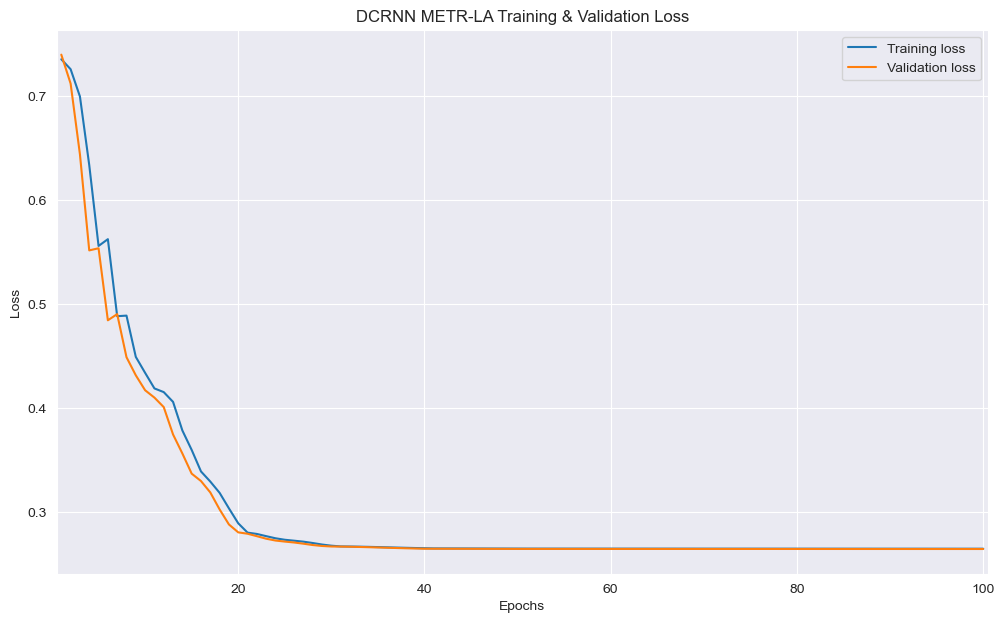

In [42]:
plot_loss(losses, title="DCRNN METR-LA Training & Validation Loss")

## Plot forecasts

In [10]:
out = np.load(os.path.join(RESULTS_PATH, "forecasts", f"{model}_{dataset}.npz"))

In [11]:
out["targets"].shape, out["forecasts"].shape

((6850, 207, 12), (6850, 207, 12))

In [15]:
targets_all = np.concatenate((out["targets"][:, :, 0], out["targets"][-11:, :, -1]))
targets_all.shape

(6861, 207)

In [63]:
h = 1
node_idx = 0
forecasts = out["forecasts"][:, node_idx, h - 1]
targets = out["targets"][:, node_idx, h - 1]
forecasts.shape, targets.shape

((6850,), (6850,))

In [64]:
mask = (targets == 0)
targets = np.where(mask, np.nan, targets)
forecasts = np.where(mask, np.nan, forecasts)

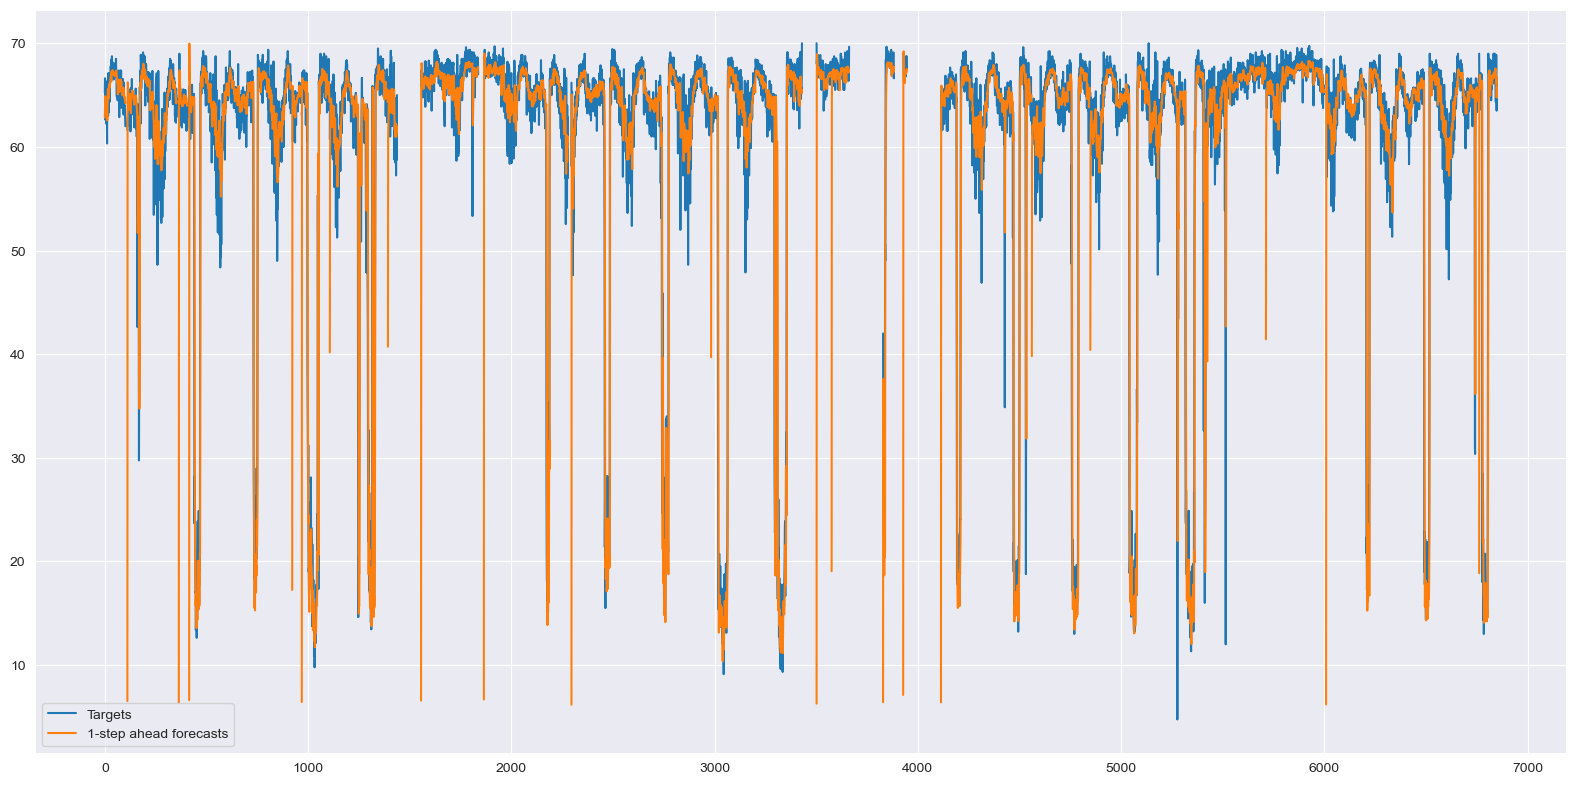

In [65]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plt.tight_layout()
ax.plot(range(targets.shape[0]), targets, label="Targets")
ax.plot(range(forecasts.shape[0]), forecasts, label=f"{h}-step ahead forecasts")
ax.legend(loc=3)

In [50]:
out["targets"][:, node_idx, h - 1][:12]

array([70. , 70.2, 71.2, 72.7, 71.9, 72. , 72. , 70.6, 70.7, 71.8, 69.1,
       69.5], dtype=float32)

In [ ]:
hs = (1, 3, 12)

In [69]:
example = np.load(os.path.join(RESULTS_PATH, "forecasts", "dcrnn_metr_debug_example.npz"))

In [71]:
example.keys()

KeysView(NpzFile '/Users/sleeper/Desktop/CS 224W/Project/CS224W_Project/results/forecasts/dcrnn_metr_debug_example.npz' with keys: train_inputs, train_outputs, train_targets, valid_inputs, valid_outputs...)

In [76]:
example["train_inputs"].round(2)

array([[68.62, 66.22, 68.12, 68.62, 67.62, 67.22, 66.25, 67.56, 66.88,
        66.88, 65.67, 66.38]], dtype=float32)

In [77]:
example["train_outputs"].round(2)

array([[54.67, 53.38, 55.24, 55.37, 51.69, 55.4 , 53.69, 53.15, 56.14,
        52.9 , 54.36, 53.19]], dtype=float32)

In [78]:
example["train_targets"].round(2)

array([[66.22, 66.5 , 67.11, 66.62, 67.67, 66.  , 66.67, 68.12, 67.75,
        67.33, 65.89, 64.75]], dtype=float32)